In [1]:
# Import necessary modules
import sys
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.abspath('src'))

In [3]:
from data_utils import load_data, DicomDataset, window_image
from model import get_unet_model
from train import train_model, BinaryDiceLoss
from evaluate import evaluate_model
from visualize import plot_training_history, visualize_segmentation

In [4]:
MAIN_DIR = 'data'               # Path to the main directory containing ZIP files
EXTRACTED_DIR = 'data/3Dircadb1'  # Path where data will be extracted

In [5]:
# Windowing parameters
hu_window = {
    'abdomen_soft': (400, 50),
    'brain_bone': (2800, 600),
    'brain_soft': (375, 40),
    'liver': (150, 30),
    'lungs': (1500, -600),
    'mediastinum': (350, 50),
    'spine_bone': (1800, 400),
    'spine_soft': (250, 50)
}

In [6]:
# Training parameters
batch_size = 16
num_epochs = 2
learning_rate = 1e-4
mask_organ = 'livertumor'  # Adjust based on your mask naming convention

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Data loading and preparation

In [7]:
# Load and process data
patient_data_l = load_data(EXTRACTED_DIR)

# Filter out None entries and prepare train-test split
valid_patient_data = [patient for patient in patient_data_l if patient is not None]
train_data, test_data = train_test_split(valid_patient_data, test_size=0.2, random_state=42)

# Initialize datasets
train_dataset = DicomDataset(train_data, hu_window=hu_window, mask_organ=mask_organ)
test_dataset = DicomDataset(test_data, hu_window=hu_window, mask_organ=mask_organ)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

No livertumor can be found with patient 5.
No livertumor can be found with patient 11.
No livertumor can be found with patient 17.
No livertumor can be found with patient 7.
No livertumor can be found with patient 19.
No livertumor can be found with patient 1.
No livertumor can be found with patient 14.
No livertumor can be found with patient 20.
No livertumor can be found with patient 8.
Number of training samples: 1310
Number of testing samples: 257


In [8]:
# Initialize the U-Net model
model = get_unet_model(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1
)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = BinaryDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
train_loss_history, train_dice_history = train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

Epoch 1/2, Loss: 0.9745, Dice Coef: 0.0074


Epoch 2/2, Loss: 0.9394, Dice Coef: 0.0088


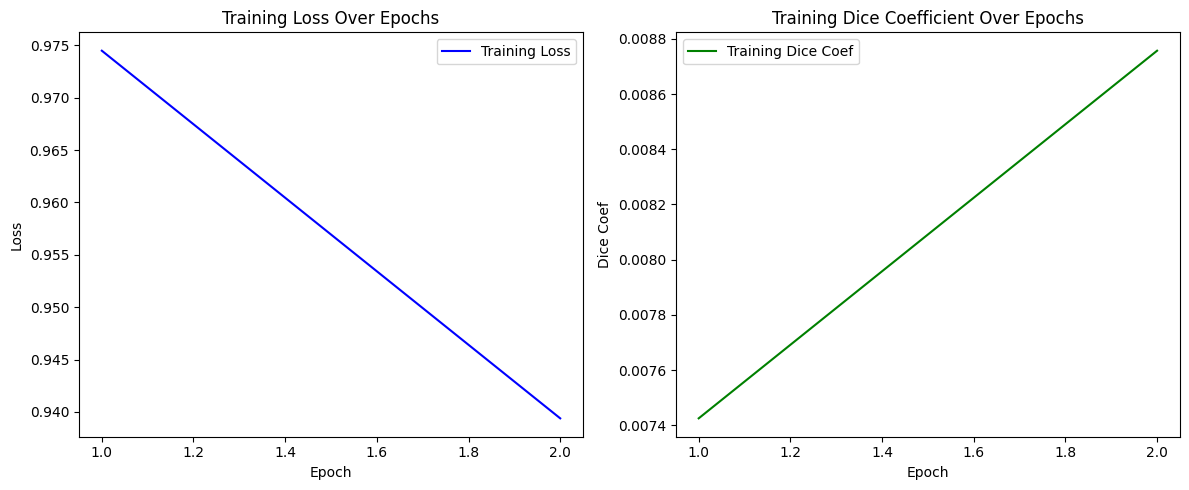

In [11]:
plot_training_history(train_loss_history, train_dice_history, num_epochs)

In [12]:
test_loss, test_dice = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device
)

Test Loss: 0.9927, Test Dice Coef: 0.0153


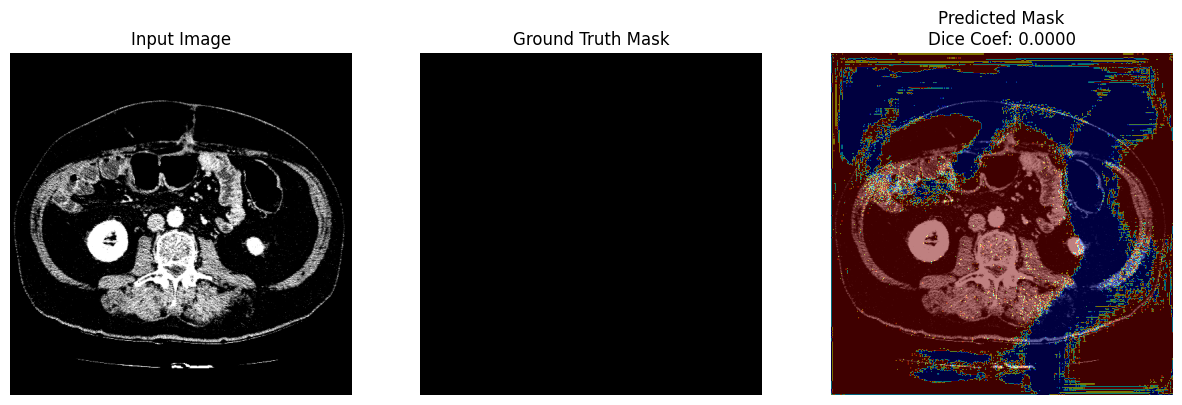

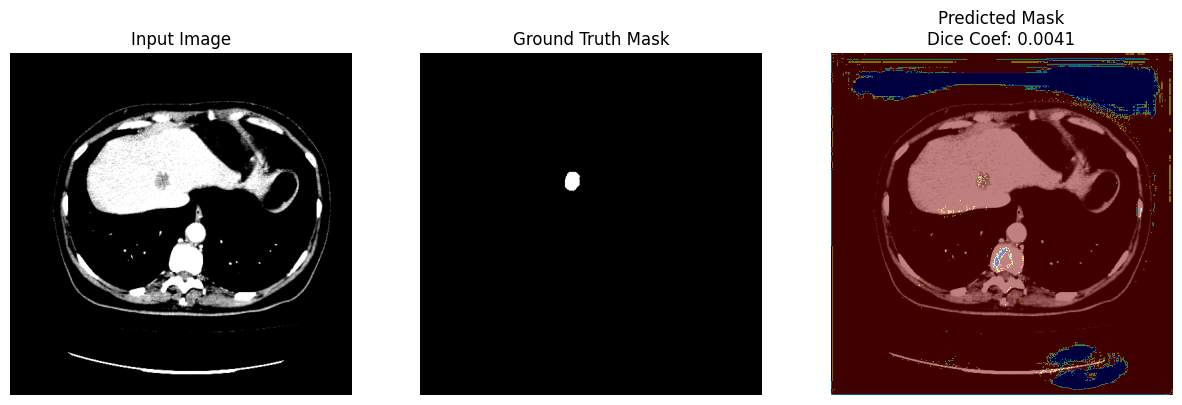

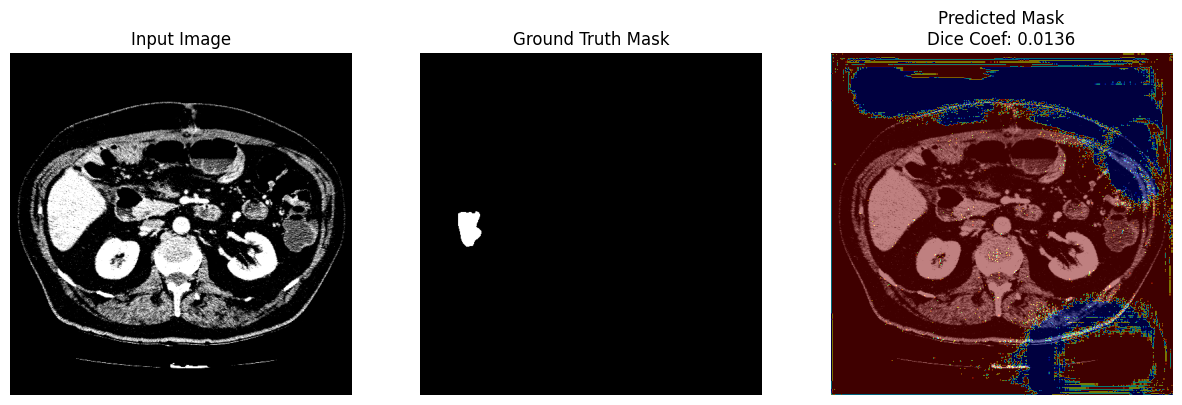

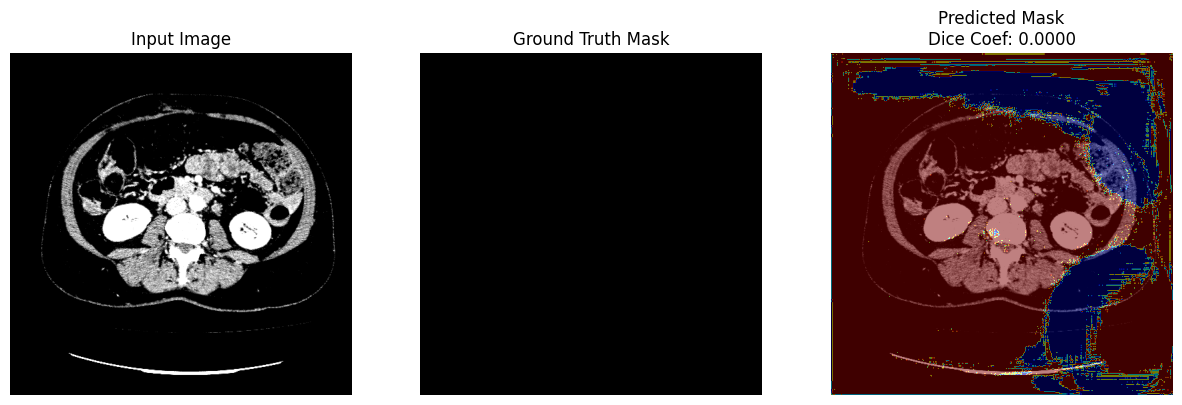

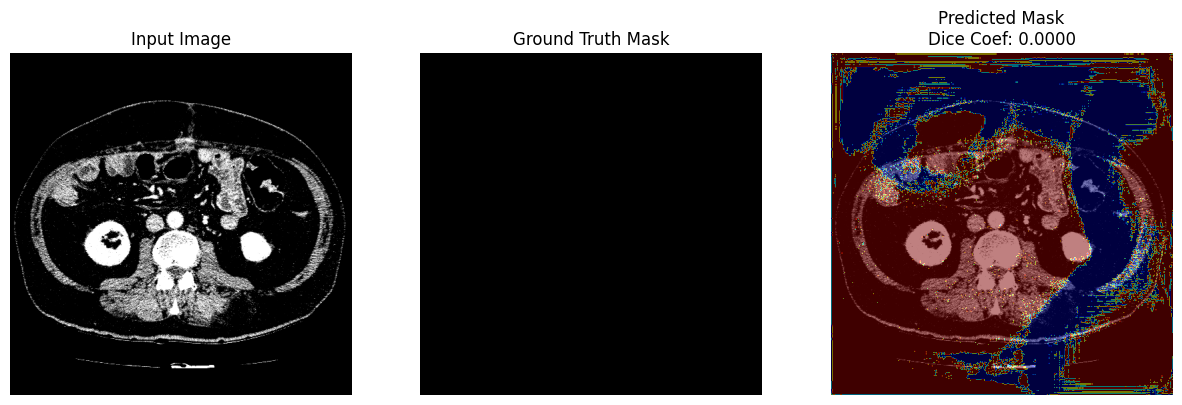

In [13]:
visualize_segmentation(
    model=model,
    dataset=test_dataset,
    device=device,
    num_samples=5
)